In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.losses import BinaryCrossentropy, binary_crossentropy
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Input, RepeatVector, Reshape, concatenate, UpSampling2D, Permute, Softmax, BatchNormalization, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import copy
import pandas as pd
import numpy as np
import os

Download dataset

In [2]:
!pip install googledrivedownloader segmentation-models
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1KVfrTao_0XzUWLI4-JgGZJOLE0ddjwto', dest_path='./data/file.zip', unzip=True)

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 669 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Unzipping...Done.
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


Make list of images and their masks

In [3]:
lst   = os.listdir('/kaggle/working/data/images/')
mask = []
img = []
for filename in lst:
    if filename.endswith('.jpg'):
        img.append('/kaggle/working/data/images/' + filename)
    if filename.endswith('.png'):
        mask.append('/kaggle/working/data/images/' + filename)

img.sort()
mask.sort()

# View input images and masks

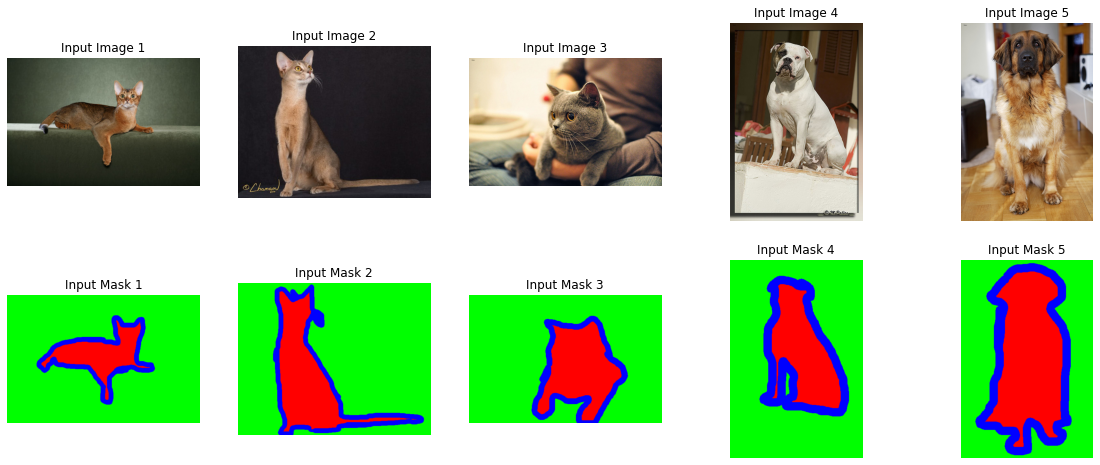

In [4]:
indexes = [0,100, 800, 2500, 5000]
sample_images, sample_masks = [], []
for x in indexes:
    temp1 = cv2.imread(img[x])
    temp2 = cv2.imread(mask[x], 0)
    temp1 = cv2.cvtColor(temp1, cv2.COLOR_BGR2RGB)
    out = np.zeros((temp2.shape[0], temp2.shape[1], 3), dtype=np.uint8)
    out[:, :, 0] = (temp2 == 1) * 255
    out[:, :, 1] = (temp2 == 2) * 255
    out[:, :, 2] = (temp2 == 3) * 255
    out = out.astype('uint')
    sample_images.append(temp1)
    sample_masks.append(out)
    
cols = 5    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8))
for i in range(len(sample_images)):
    axes[i//cols, i%cols].set_title('Input Image ' + str(i+1))
    axes[i//cols, i%cols].axis('off')
    axes[i//cols, i%cols].imshow(sample_images[i])
    
    axes[i//cols + 1, i%cols].set_title('Input Mask ' + str(i+1))
    axes[i//cols + 1, i%cols].axis('off')
    axes[i//cols + 1, i%cols].imshow(sample_masks[i])
fig.savefig('Input_Images_and_Masks.eps', format='eps')

# Data Preprocessing
Set masks to RGB values

In [5]:
!mkdir /kaggle/working/data2/images -p
for i in tqdm(range(len(mask))):
    msk = cv2.imread(mask[i], 0)
    out = np.zeros((msk.shape[0], msk.shape[1], 3), dtype=np.uint8)
    out[:, :, 0] = (msk == 1) * 255
    out[:, :, 1] = (msk == 2) * 255
    out[:, :, 2] = (msk == 3) * 255
    path = mask[i].replace('data', 'data2')
    cv2.imwrite(path, out)
    mask[i] = mask[i].replace('data', 'data2')

Train and validation split

In [6]:
df = pd.DataFrame({'Filepath_Image':img, 'Filepath_Mask':mask})
train, val = train_test_split(df, test_size=0.2, random_state = 0)

epoch_count = 50
batch_size_count = 16

steps_count = len(train) // batch_size_count
val_steps_count = len(val) // batch_size_count

# Data Augmentation
Zoom, horizontal flips, rotation, width and height shift are applied at random

In [7]:
datagen = ImageDataGenerator(rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        #samplewise_center = True,
        )

datagen_val = ImageDataGenerator(rescale=1./255)

train_img_flow = datagen.flow_from_dataframe(train, x_col = 'Filepath_Image', class_mode = None, interpolation = 'bicubic', batch_size = batch_size_count, seed = 42)
train_mask_flow = datagen.flow_from_dataframe(train, x_col = 'Filepath_Mask', class_mode = None, interpolation = 'nearest', batch_size = batch_size_count, seed = 42)
train_flow = zip(train_img_flow, train_mask_flow)

val_img_flow = datagen_val.flow_from_dataframe(val, x_col = 'Filepath_Image', class_mode = None, interpolation = 'bicubic', batch_size = batch_size_count, seed = 12)
val_mask_flow = datagen_val.flow_from_dataframe(val, x_col = 'Filepath_Mask', class_mode = None, interpolation = 'nearest', batch_size = batch_size_count, seed = 12)
val_flow = zip(val_img_flow, val_mask_flow)

Found 5904 validated image filenames.
Found 5904 validated image filenames.
Found 1477 validated image filenames.
Found 1477 validated image filenames.


# UNet
Unet with resnet34 backbone and loss as combination of binary cross entropy and jaccard loss

In [8]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def UNet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=3, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='UNet')
    model.summary()
    return model

In [9]:
model = sm.Unet('resnet34', input_shape=(256, 256, 3), encoder_weights=None, classes=3, activation='softmax')
opt = optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.01, min_lr = 1e-8)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

# Fit Model
Train on train images and validate on validation images

In [10]:
history = model.fit(train_flow, epochs = epoch_count, steps_per_epoch=steps_count, validation_data = val_flow, validation_steps=val_steps_count)#, callbacks=[reduce_lr])

Epoch 1/50
369/369 [==============================] - 265s 719ms/step - loss: 0.9642 - iou_score: 0.4332 - val_loss: 0.9288 - val_iou_score: 0.5141
Epoch 2/50
369/369 [==============================] - 270s 733ms/step - loss: 0.7948 - iou_score: 0.5270 - val_loss: 0.6845 - val_iou_score: 0.6114
Epoch 3/50
369/369 [==============================] - 273s 739ms/step - loss: 0.7239 - iou_score: 0.5676 - val_loss: 1.0654 - val_iou_score: 0.5102
Epoch 4/50
369/369 [==============================] - 277s 750ms/step - loss: 0.6800 - iou_score: 0.5923 - val_loss: 0.7903 - val_iou_score: 0.5556
Epoch 5/50
369/369 [==============================] - 279s 757ms/step - loss: 0.6575 - iou_score: 0.6047 - val_loss: 0.6194 - val_iou_score: 0.6211
Epoch 6/50
369/369 [==============================] - 283s 768ms/step - loss: 0.6363 - iou_score: 0.6171 - val_loss: 0.5777 - val_iou_score: 0.6541
Epoch 7/50
369/369 [==============================] - 285s 773ms/step - loss: 0.6203 - iou_score: 0.6256 - val_l

View loss and IOU score on train and validation

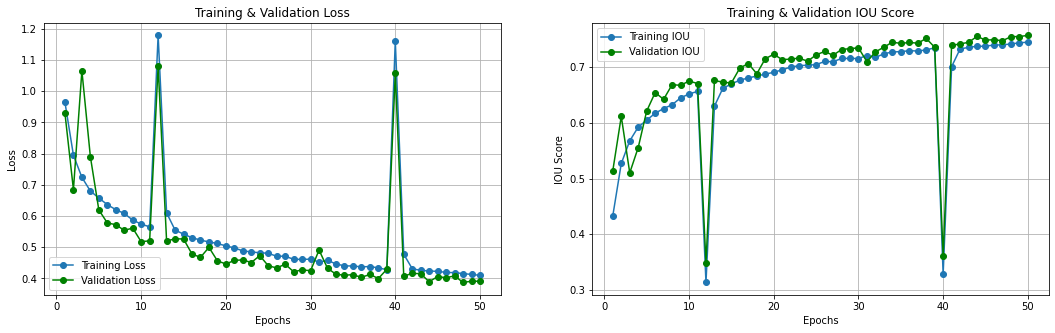

In [11]:
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
epochs = range(1, len(history.history['iou_score'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

acc_vals = history.history['iou_score']
val_acc_vals = history.history['val_iou_score']

ax[1].plot(epochs, acc_vals, marker='o', label='Training IOU')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation IOU')
ax[1].set_title('Training & Validation IOU Score')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('IOU Score')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()
del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

# Perform segmentation on new images

In [12]:
img_url = ['https://pbs.twimg.com/profile_images/378800000532546226/dbe5f0727b69487016ffd67a6689e75a.jpeg',
           'https://www.k9rl.com/wp-content/uploads/2017/01/Tibetan-Spaniel-dog.jpg',
           'https://upload.wikimedia.org/wikipedia/commons/a/ac/Bombay_femelle.JPG',
           'https://www.guidedogs.org/wp-content/uploads/2019/11/website-donate-mobile.jpg',
           'https://i.imgur.com/drfirIW.jpg'
          ]
img_get = []
!mkdir Downloaded_Images -p
for i in range(len(img_url)):
    Image.open(BytesIO(requests.get(img_url[i]).content)).save('/kaggle/working/Downloaded_Images/image' + str(i) + '.png')
    
# Load Images to array
new_images = []
for i in range(len(img_url)):
    temp = tf.keras.preprocessing.image.load_img( '/kaggle/working/Downloaded_Images/image' + str(i) + '.png', color_mode = "rgb")
    temp = np.array(temp)
    temp = tf.image.resize_with_pad(temp, 256, 256, method='bicubic').numpy()
    temp = temp.astype('uint8')
    temp = temp / 255.0
    new_images.append(temp)
new_images = np.array(new_images)

# Store predictions
predictions = model.predict(new_images)

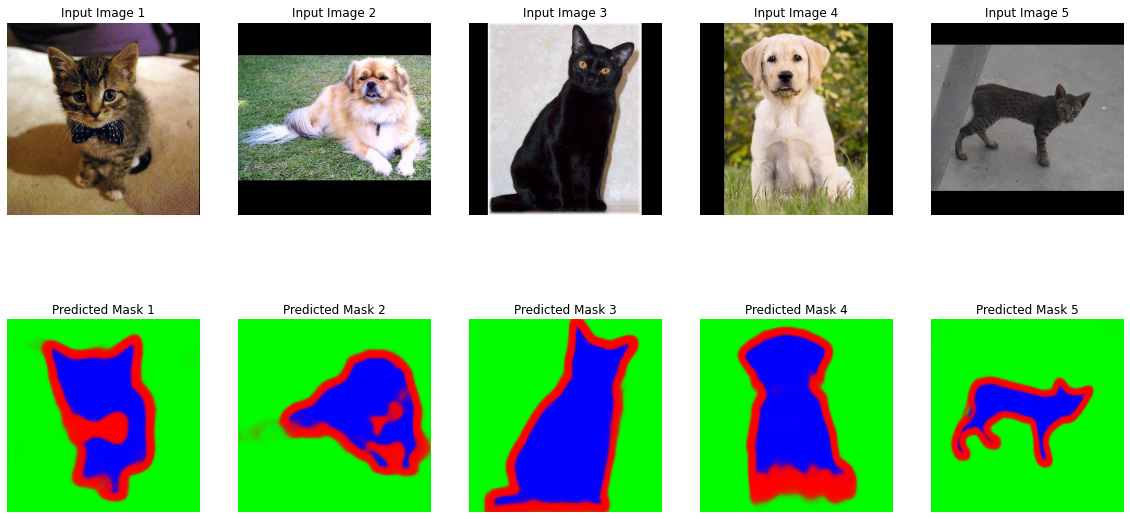

In [13]:
##### Print images and their predicitons #####
rows, cols = (((len(new_images) - 1) // 5 ) + 1) * 2, 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,10))
for i in range(len(new_images)):
    axes[i//cols, i%cols].set_title('Input Image ' + str(i+1))
    axes[i//cols, i%cols].axis('off')
    axes[i//cols, i%cols].imshow(new_images[i])
    
    axes[i//cols + 1, i%cols].set_title('Predicted Mask ' + str(i+1))
    axes[i//cols + 1, i%cols].axis('off')
    axes[i//cols + 1, i%cols].imshow(predictions[i])
fig.savefig('New_Images_Mask_Prediction.eps', format='eps')